임베딩 모델 적용

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
df = pd.read_csv("Rdata.csv")
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")



texts = df['review'].astype(str).tolist()
embeddings = [model.encode(text, show_progress_bar=False) for text in tqdm(texts, desc="임베딩 생성 중")]



df['임베딩'] = [embedding.tolist() for embedding in embeddings]


df.to_csv("Rdata_embadding.csv", index=False)
print("임베딩 완료! 결과가 'Rdata_embadding.csv'에 저장되었습니다.")

임베딩 생성 중: 100%|██████████| 215/215 [00:27<00:00,  7.93it/s]


임베딩 완료! 결과가 'Rdata_embadding.csv'에 저장되었습니다.


In [3]:
df = pd.read_csv("Rdata_embadding.csv")

df.head()

,카페이름,review,임베딩
0,FFEE,아메라카노 원두 세가지 중에 고를 수 있어서 취향에 맞게 먹을 수 있어 좋아요. 물...,"[-1.132696270942688, -0.792607307434082, -0.94..."
1,MouseRabbit카페,노트북 작업하기 좋은 곳이에용. 지하는 좌식이고 분위기가 다르네요. 좀 더 따뜻한 ...,"[-0.4443735182285309, -1.06172776222229, -0.45..."
2,"TAKEN COFFEE 건대후문점카페,디저트",저의 최애커피집이에요 너무 맛있고 좋아요 점심에 항상 바쁜데도 늘 친절해요\r\n음...,"[-0.7025462985038757, -0.8724941611289978, -0...."
3,TWG Tea 성수낙낙점,모든 소품들이 twg 로고가 박혀있어 정말 고급스러워서 대접 받는 느낌에 더 맛나게...,"[-0.9923424124717712, -0.8493466377258301, -0...."
4,"걈카페,디저트",조아요 커피 맛있어요! 케이크도! 진짜 아지트같은 카페에여ㅠㅠ최애 좌석이 편하고 콘...,"[-0.6285426020622253, -0.9752342700958252, -0...."


------------------------------------------------------------------------------------------------------------------

클러스터링 - KMeans

클러스터링 완료! 결과가 'Rdata_kmeans.csv'에 저장되었습니다.


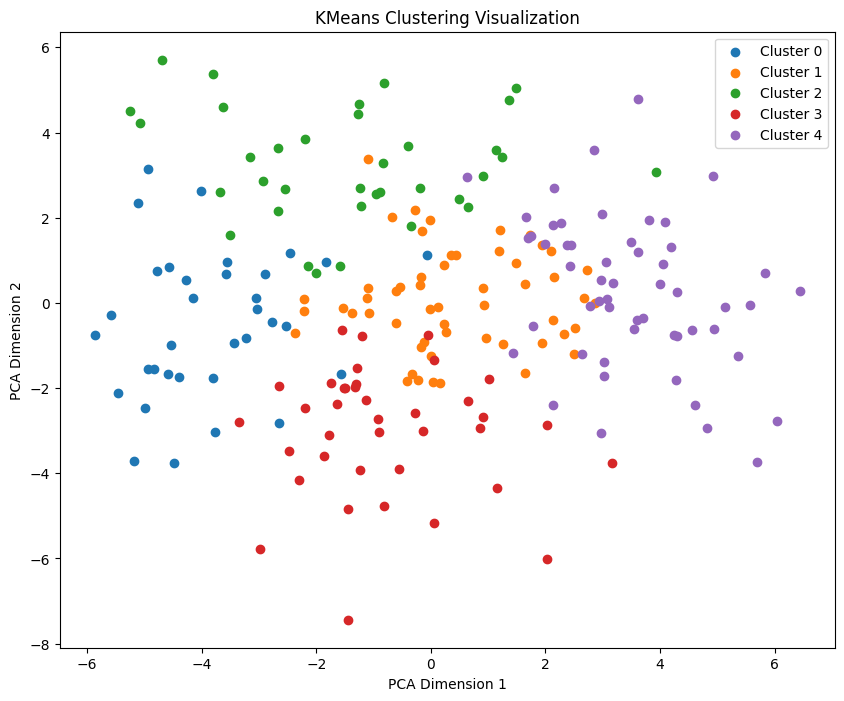

In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#클러스터링 ---------------------------------------------------------------------------------
df = pd.read_csv("Rdata_embadding.csv")

embeddings = df['임베딩'].apply(eval).tolist()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['클러스터'] = kmeans.fit_predict(embeddings)

output_file = "Rdata_kmeans.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"클러스터링 완료! 결과가 '{output_file}'에 저장되었습니다.")

#시각화 ---------------------------------------------------------------------------------
df = pd.read_csv("Rdata_kmeans.csv")
embeddings = df['임베딩'].apply(eval).tolist()

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
n_clusters = df['클러스터'].nunique()
for cluster in range(n_clusters):
    cluster_points = reduced_embeddings[df['클러스터'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [7]:
import pandas as pd

file_path = 'Rdata_kmeans.csv'
df = pd.read_csv(file_path)

df = df.drop(df.columns[2], axis=1)

output_file = 'Rdata_kmeans.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: {output_file}")

3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: Rdata_kmeans.csv


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('Rdata_kmeans.csv')

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # 최대 1000개의 단어, 불용어 제거
tfidf_matrix = vectorizer.fit_transform(df['review'])  # 리뷰 텍스트를 TF-IDF로 변환
feature_names = vectorizer.get_feature_names_out()  # 단어 목록

# 클러스터별 주요 키워드 추출
for cluster in df['클러스터'].unique():
    if cluster == -1:  # 노이즈 클러스터 제외
        continue
    cluster_indices = df[df['클러스터'] == cluster].index  # 클러스터에 속한 데이터 인덱스
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)  # 클러스터 내 TF-IDF 평균 계산
    top_indices = np.argsort(cluster_tfidf.A.flatten())[::-1][:10]  # 상위 10개 단어 인덱스
    top_keywords = [(feature_names[i], cluster_tfidf[0, i]) for i in top_indices]
    print(f"Cluster {cluster} 주요 키워드: {top_keywords}")

Cluster 4 주요 키워드: [('좋아요', np.float64(0.24253635703838966)), ('너무', np.float64(0.19996272194612177)), ('맛있어요', np.float64(0.1653827901277097)), ('카페', np.float64(0.10688688980417226)), ('커피', np.float64(0.10522573232977842)), ('좋고', np.float64(0.07902503211390403)), ('커피도', np.float64(0.07850522312577705)), ('맛있고', np.float64(0.07343971509250843)), ('분위기', np.float64(0.07208658891073778)), ('좋은', np.float64(0.06895476968910755))]
Cluster 0 주요 키워드: [('너무', np.float64(0.19689400631654314)), ('맛있어요', np.float64(0.16234504332556218)), ('케이크', np.float64(0.12408076624417938)), ('좋아요', np.float64(0.09856751811196666)), ('진짜', np.float64(0.07190544371659904)), ('와플', np.float64(0.06640594658854107)), ('정말', np.float64(0.058710076305045496)), ('케이크가', np.float64(0.04562265973207496)), ('맛있게', np.float64(0.04395167969314917)), ('맛있고', np.float64(0.04156613552501989))]
Cluster 1 주요 키워드: [('좋아요', np.float64(0.23276807628178206)), ('맛있어요', np.float64(0.21461251026887235)), ('너무', np.float64(0.1605

------------------------------------------------------------------------------------------------------------------


클러스터링 - DBSCAN

DBSCAN 클러스터링 완료! 결과가 'Rdata_DBSCAN.csv'에 저장되었습니다.


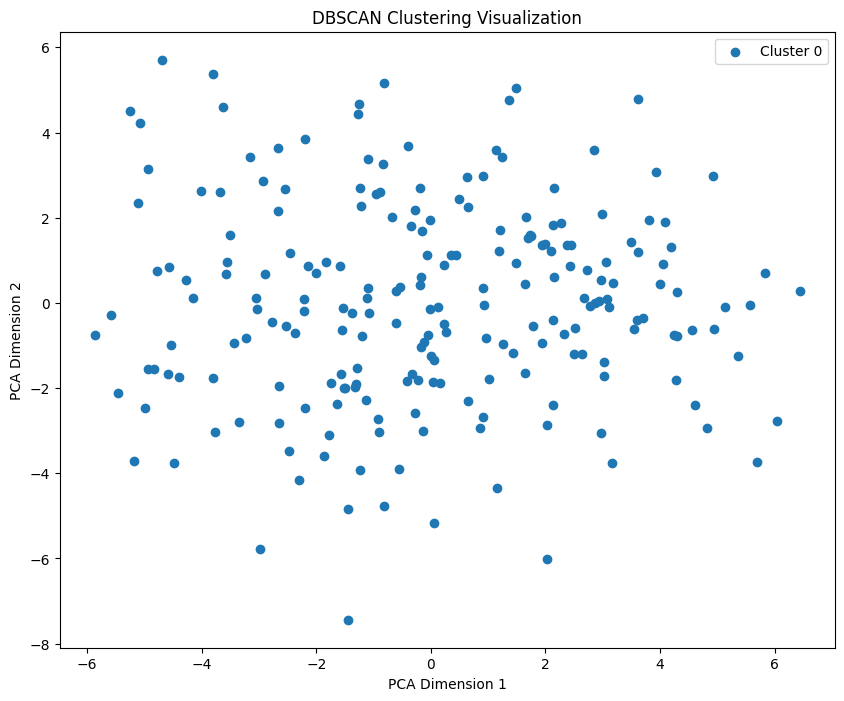

In [13]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
df = pd.read_csv("Rdata_embadding.csv")

# DBSCAN 클러스터링 ---------------------------------------------------------------------------------

embeddings = df['임베딩'].apply(eval).tolist()

dbscan = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
df['클러스터'] = dbscan.fit_predict(embeddings)  

output_file = "Rdata_DBSCAN.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"DBSCAN 클러스터링 완료! 결과가 '{output_file}'에 저장되었습니다.")

# 시각화 ---------------------------------------------------------------------------------

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
unique_clusters = df['클러스터'].unique()
for cluster in unique_clusters:
    cluster_points = reduced_embeddings[df['클러스터'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}" if cluster != -1 else "Noise")

plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

----------------------------------------------------------------------------------------------------------

클러스터링 - HDBSCAN

c:\Users\santa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\santa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN 클러스터링 완료! 결과가 'Rdata_HDBSCAN.csv'에 저장되었습니다.


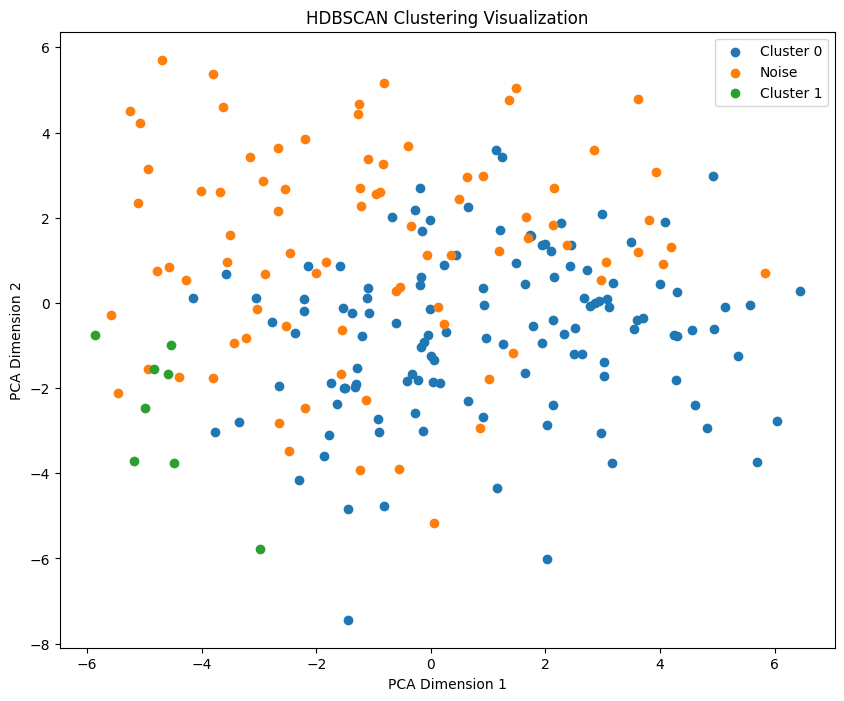

In [28]:
import pandas as pd
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# HDBSCAN 클러스터링 ---------------------------------------------------------------------------------

df = pd.read_csv("Rdata_embadding.csv")

embeddings = df['임베딩'].apply(eval).tolist()

hdbscan = HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean')
df['클러스터'] = hdbscan.fit_predict(embeddings)

output_file = "Rdata_HDBSCAN.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"HDBSCAN 클러스터링 완료! 결과가 '{output_file}'에 저장되었습니다.")

# 시각화 ---------------------------------------------------------------------------------

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
unique_clusters = df['클러스터'].unique()
for cluster in unique_clusters:
    cluster_points = reduced_embeddings[df['클러스터'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}" if cluster != -1 else "Noise")

plt.title("HDBSCAN Clustering Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [32]:
df =pd.read_csv("Rdata_HDBSCAN.csv")

df = df.drop(df.columns[2], axis=1)

output_file = "Rdata_HDBSCAN.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: {output_file}")

3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: Rdata_HDBSCAN.csv


----------------------------------------------------------------------------------------------------

클러스터링 - Agglomerative

Agglomerative Clustering 완료! 결과가 'Rdata_Agglomerative.csv'에 저장되었습니다.


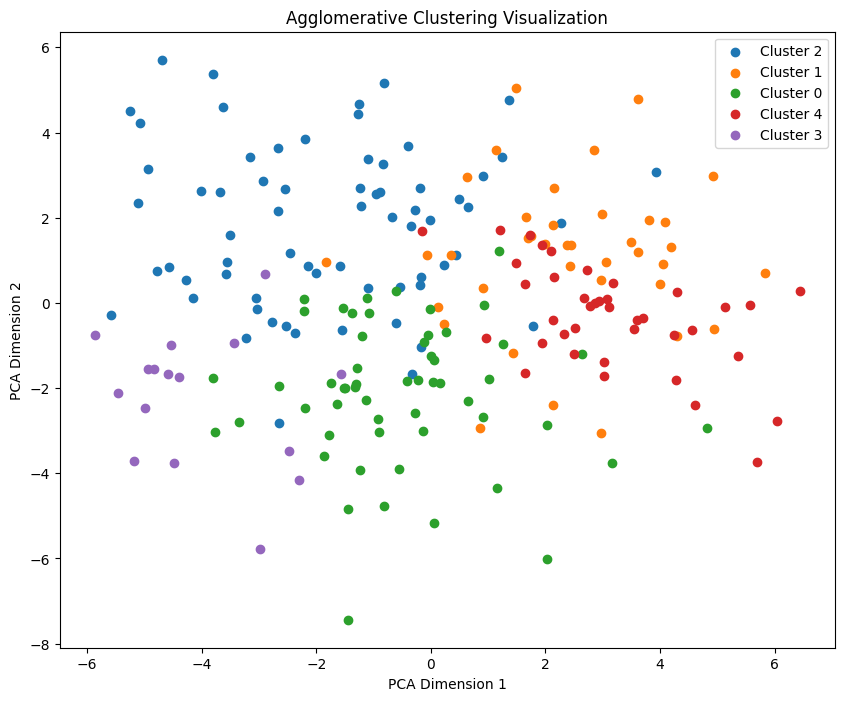

In [30]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Agglomerative Clustering ---------------------------------------------------------------------------------

df = pd.read_csv("Rdata_embadding.csv")

embeddings = df['임베딩'].apply(eval).tolist()

n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['클러스터'] = agg_clustering.fit_predict(embeddings)

output_file = "Rdata_Agglomerative.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Agglomerative Clustering 완료! 결과가 '{output_file}'에 저장되었습니다.")

# 시각화 ---------------------------------------------------------------------------------

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
unique_clusters = df['클러스터'].unique()
for cluster in unique_clusters:
    cluster_points = reduced_embeddings[df['클러스터'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("Agglomerative Clustering Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [31]:
df =pd.read_csv('Rdata_Agglomerative.csv')

df = df.drop(df.columns[2], axis=1)

output_file = 'Rdata_Agglomerative.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: {output_file}")

3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: Rdata_Agglomerative.csv


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('Rdata_Agglomerative.csv')

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # 최대 1000개의 단어, 불용어 제거
tfidf_matrix = vectorizer.fit_transform(df['review'])  # 리뷰 텍스트를 TF-IDF로 변환
feature_names = vectorizer.get_feature_names_out()  # 단어 목록

# 클러스터별 주요 키워드 추출
for cluster in df['클러스터'].unique():
    if cluster == -1:  # 노이즈 클러스터 제외
        continue
    cluster_indices = df[df['클러스터'] == cluster].index  # 클러스터에 속한 데이터 인덱스
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)  # 클러스터 내 TF-IDF 평균 계산
    top_indices = np.argsort(cluster_tfidf.A.flatten())[::-1][:10]  # 상위 10개 단어 인덱스
    top_keywords = [(feature_names[i], cluster_tfidf[0, i]) for i in top_indices]
    print(f"Cluster {cluster} 주요 키워드: {top_keywords}")

Cluster 2 주요 키워드: [('맛있어요', np.float64(0.19121130816373547)), ('너무', np.float64(0.18638345051183344)), ('좋아요', np.float64(0.12145446290842858)), ('진짜', np.float64(0.06302711764970502)), ('맛있고', np.float64(0.055654891509018534)), ('정말', np.float64(0.05436813319321402)), ('좋고', np.float64(0.05319896390745094)), ('카페', np.float64(0.050033246006374064)), ('있어서', np.float64(0.04745110136310304)), ('커피', np.float64(0.04269886050671687))]
Cluster 1 주요 키워드: [('좋아요', np.float64(0.21797326078061316)), ('너무', np.float64(0.19167278923107864)), ('맛있어요', np.float64(0.15184070558369542)), ('카페', np.float64(0.09011598629868457)), ('좋고', np.float64(0.07496358939359216)), ('커피', np.float64(0.07202358187276643)), ('넓고', np.float64(0.07197785099158137)), ('분위기', np.float64(0.06542470884009167)), ('커피도', np.float64(0.06390031892730369)), ('맛있고', np.float64(0.06359941904797817))]
Cluster 0 주요 키워드: [('좋아요', np.float64(0.25844048324949204)), ('맛있어요', np.float64(0.2560642667606199)), ('너무', np.float64(0.138975

--------------------------------------------------------------------------------------

클러스터링 - Spectral Clustering

Spectral Clustering 완료! 결과가 'Rdata_Spectral.csv'에 저장되었습니다.


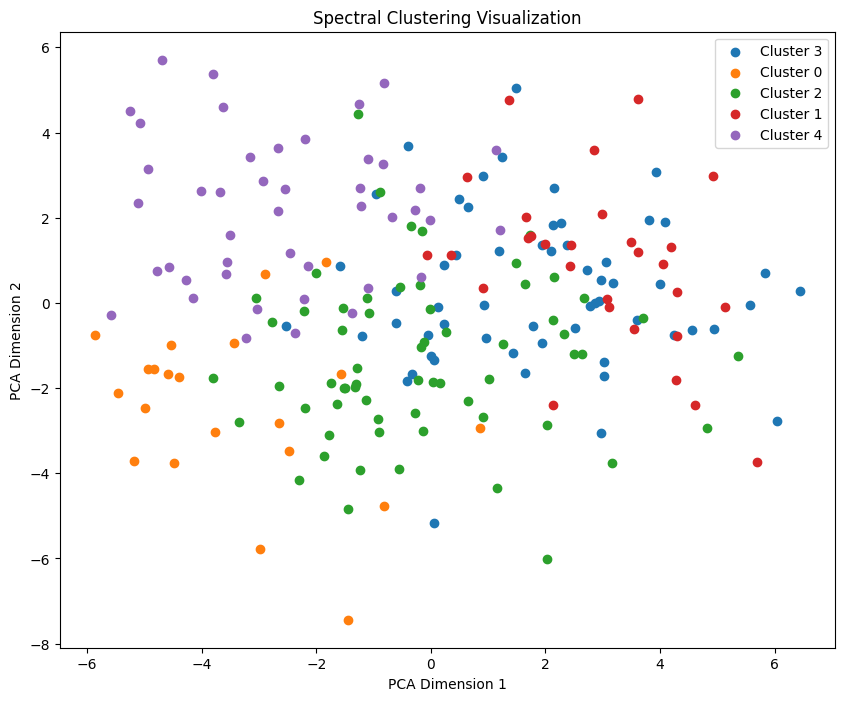

In [37]:
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 데이터 로드
df = pd.read_csv("Rdata_embadding.csv")

# 임베딩 데이터를 리스트로 변환
embeddings = df['임베딩'].apply(eval).tolist()

# 유사도 행렬 계산 (코사인 유사도)
similarity_matrix = cosine_similarity(embeddings)

# Spectral Clustering 수행
n_clusters = 5  # 원하는 클러스터 개수 설정
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
df['클러스터'] = spectral_clustering.fit_predict(similarity_matrix)

# 결과 저장
output_file = "Rdata_Spectral.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Spectral Clustering 완료! 결과가 '{output_file}'에 저장되었습니다.")

# PCA를 사용하여 차원 축소
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(10, 8))
unique_clusters = df['클러스터'].unique()
for cluster in unique_clusters:
    cluster_points = reduced_embeddings[df['클러스터'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("Spectral Clustering Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [38]:
df =pd.read_csv("Rdata_Spectral.csv")

df = df.drop(df.columns[2], axis=1)

output_file = "Rdata_Spectral.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: {output_file}")

3열(임베딩벡터)이 제거된 데이터가 저장되었습니다: Rdata_Spectral.csv


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv("Rdata_Spectral.csv")

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # 최대 1000개의 단어, 불용어 제거
tfidf_matrix = vectorizer.fit_transform(df['review'])  # 리뷰 텍스트를 TF-IDF로 변환
feature_names = vectorizer.get_feature_names_out()  # 단어 목록

# 클러스터별 주요 키워드 추출
for cluster in df['클러스터'].unique():
    if cluster == -1:  # 노이즈 클러스터 제외
        continue
    cluster_indices = df[df['클러스터'] == cluster].index  # 클러스터에 속한 데이터 인덱스
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)  # 클러스터 내 TF-IDF 평균 계산
    top_indices = np.argsort(cluster_tfidf.A.flatten())[::-1][:10]  # 상위 10개 단어 인덱스
    top_keywords = [(feature_names[i], cluster_tfidf[0, i]) for i in top_indices]
    print(f"Cluster {cluster} 주요 키워드: {top_keywords}")

Cluster 3 주요 키워드: [('너무', np.float64(0.24931705613716915)), ('맛있어요', np.float64(0.1452332835454146)), ('좋아요', np.float64(0.1286539141051127)), ('카페', np.float64(0.11731597107277243)), ('커피', np.float64(0.10309256981572723)), ('좋고', np.float64(0.09247724695448035)), ('맛있고', np.float64(0.08811882164153714)), ('분위기도', np.float64(0.0828996304414653)), ('분위기', np.float64(0.07522548071904298)), ('커피도', np.float64(0.0751374614638975))]
Cluster 0 주요 키워드: [('너무', np.float64(0.2538026757249034)), ('케이크', np.float64(0.23473740312040345)), ('좋아요', np.float64(0.12048418069602738)), ('맛있어요', np.float64(0.10948996223875065)), ('레터링', np.float64(0.07735246908892289)), ('케이크가', np.float64(0.0736522628863398)), ('케이크도', np.float64(0.07285013095846445)), ('진짜', np.float64(0.07255891363756048)), ('케이크를', np.float64(0.06816994900219327)), ('정말', np.float64(0.06288710271545886))]
Cluster 2 주요 키워드: [('좋아요', np.float64(0.2940358104454561)), ('맛있어요', np.float64(0.2522918483145002)), ('너무', np.float64(0.1258251